In [6]:
import imgtda
from imgtda.locally_striped import defect_analysis as ls

import numpy as np
import pandas as pd
from scipy import misc

%matplotlib inline

In [7]:
## Set user-defined variables
roll_width = 20
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2015_09_16_fast/g21flow'
sBmp = 'bmps/%06d.bmp'
sFeatureVectors = 'feature_vectors/%06d.txt'
sSubPD = 'pd_sub/%06d.csv'
sSupPD = 'pd_sup/%06d.csv'

delta = 10

## Utility Functions

In [8]:
def loadData(idx):
    
    im = imgtda.image.load_image_from_file(sDir + "/" + (sBmp % idx))
    im.generate_orientation_field(3,1)
    im.load_sublevel_pd(sDir + "/" + (sSubPD % idx))
    im.load_superlevel_pd(sDir + "/" + (sSupPD % idx))
    
    # Get H1 generators for spiral/target disambiguation
    ph_dim1_sub = im.persistence_diagrams['sub'].loc[(im.persistence_diagrams['sub']['dim']==1) & 
                        ((im.persistence_diagrams['sub']['death'] - im.persistence_diagrams['sub']['birth']) >= delta) & 
                        (im.persistence_diagrams['sub']['birth']<=127)][['d_x','d_y']]
    ph_dim1_sup = im.persistence_diagrams['sup'].loc[(im.persistence_diagrams['sup']['dim']==1) & 
                        ((im.persistence_diagrams['sup']['birth'] - im.persistence_diagrams['sup']['death']) >= delta) & 
                        (im.persistence_diagrams['sup']['birth']>=127)][['b_x','b_y']]
    h1gens = np.vstack((ph_dim1_sub, ph_dim1_sup))
    h1gens = pd.DataFrame(h1gens, columns=['col', 'row'])
    
    persistence_h1_gens = np.zeros(im.bmp.shape)
    persistence_h1_gens[h1gens['row'], h1gens['col']] = 1
    
    return (im.bmp, im.orientation_fields[3].topological_defects, persistence_h1_gens)


## Classify Defects for a Single Image

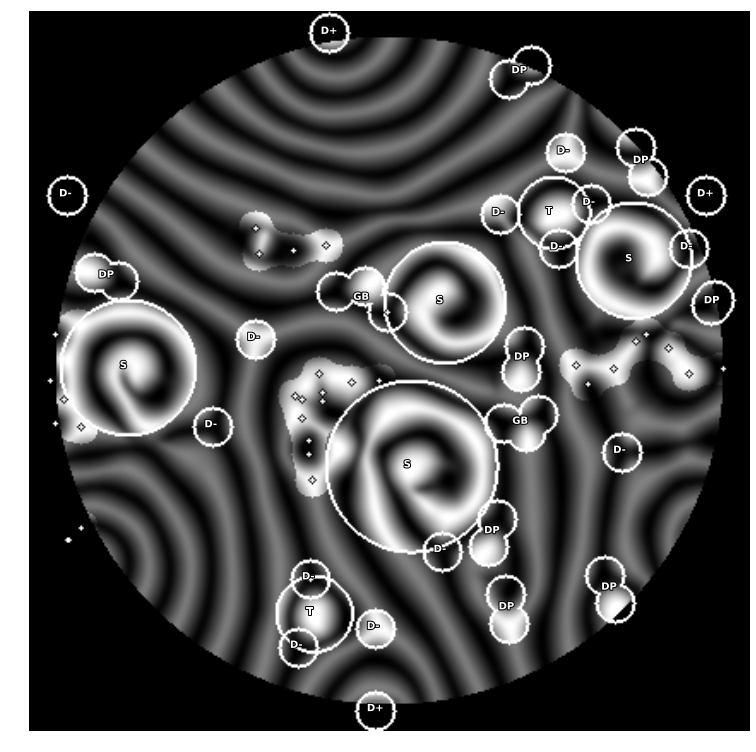

In [9]:
idx = 100

(bmp, td_classify, persistence_h1_gens) = loadData(idx)

# Process defects
radius = 10

# Get the defects
all_defects = ls.classify_all_defects(bmp, td_classify, persistence_h1_gens, radius)

# Combine defects by type
defect_regions = ls.combine_classified_defects_into_regions(bmp, all_defects)

# Aggregate the entire classified region
classified_region = np.zeros(bmp.shape)
for region in defect_regions:
    classified_region = classified_region + defect_regions[region]
    
# Compute the unclassified region and defect-free region
unclassified_defect_region = ls.get_unclassified_defect_region(classified_region, td_classify, radius)
defect_free_region = ls.get_defect_free_region(classified_region, unclassified_defect_region)

# Plot the results
# Crop the temperature field to a circle first.
c = np.zeros((421,421))
centerx = 210
centery = 210
radius=195
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        if ((i-centerx)**2 + (j-centery)**2 < radius**2):
            c[i,j] = 1
c = c.astype(np.int)
print_bmp = bmp
print_bmp[c==0] = 0
fig = ls.plot_defect_classifications(print_bmp, all_defects, unclassified_defect_region, td_classify, defect_free_region);

